# Tutorial 2

We continue from Tutorial 1. 

Our main aim here is that we want to be able to add more factors that could explain the firing rate of the neurons.

The idea is that we get one $X_{i}^{T}$ and $w_{i}$ per factor (Position, Head-Direction, Egocentric tuning, Speed). Their outputs are summed before being pass through the exponential function.

$r = exp(\sum\limits_{i} X_{i}^T w_{i})*dt$

A sum in the power is equivalent to a multiplication of the contributions. If we have Position and Head Direction components: $e^{P+H} = e^{P}e^{H}$. This seems to be appropriate based on Hardcastle et al. Figure S2.

### Possible models

We will need a flexible approach to be able to test all model combinations. 

* 1 fixed-rate model
* 4 single variable models: (P, H, E, S)
* 6 double variable models: (PH, PE, PS, HE, HS, ES)
* 4 triple varialbe models: (PHE, PHS, PES, HES)
* 1 quadruple variable model: (PHES)

This is 15 possible models per neuron.

### Flexible design

We could define a **class** for our model that would do a few tasks:

* Creating the behavioral state matrix for individual components
* Creating the learned parameters for individual components
* Calculations associated with calculating the individual rate components $w$@$X^T$
* A function to concatenate all parameters $w$ into a 1D array.
* A function to recover the different $w$ from a 1D array. 
* A function to calcluate the firing rates.

When creating an object, we would just need to set to True the components we want to include.

We need to store all parameter into a 1D array and recover them in the objective function. This is required because scipy.optimize.minimize() takes a single array of parameters. More info [here](https://stackoverflow.com/questions/31292374/how-do-i-put-2-matrix-into-scipy-optimize-minimize).


### Evaluation of models

We can do a 10-fold validation in which we get calculate the log-likelihood of held out data under the model.

## Example with a simulated neuron encoding position and head-direction

To test whether our computations are working as expected, we will simulate a neuron encoding both Position (P) and Head Direction (H). We will test the P, H, PH and PHE models with this neuron. 

We now want to have position in 2D as in most experiment and head direction as a circular 1D vector.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson, norm, vonmises
from scipy.special import factorial
import animal_trajectory

plt.rcParams["figure.figsize"] = (25, 5)

Rec time:700 sec
dt:0.02 sec
samples:35000


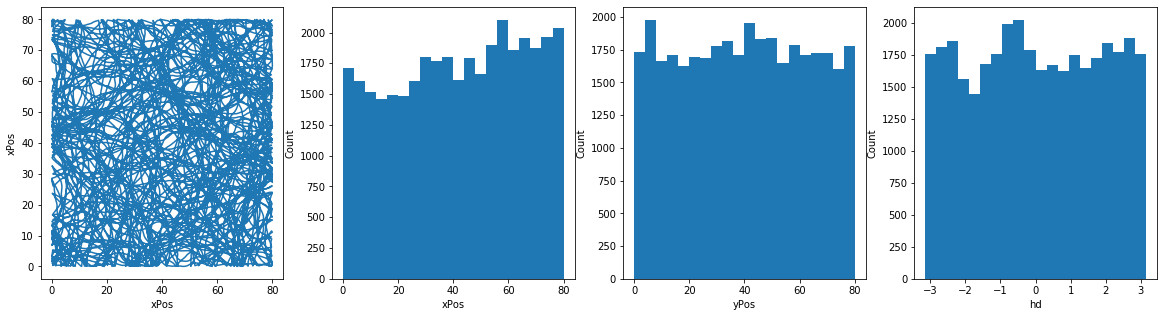

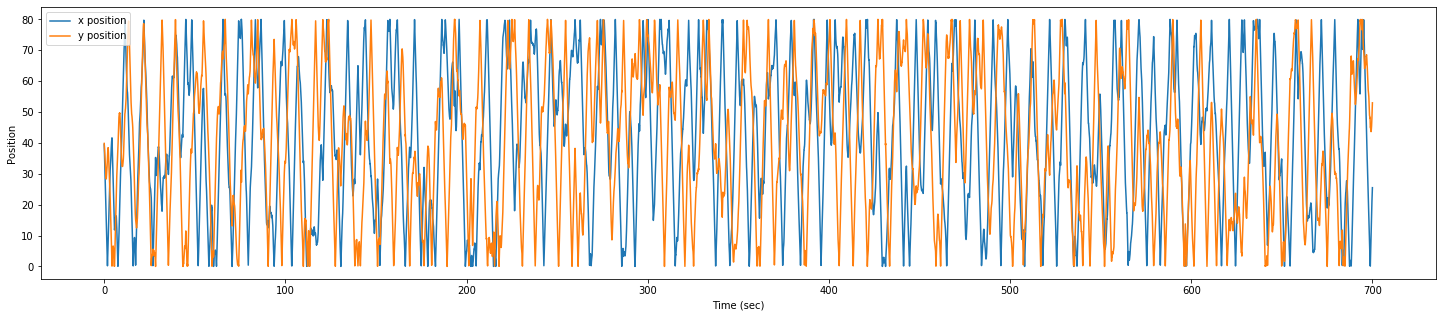

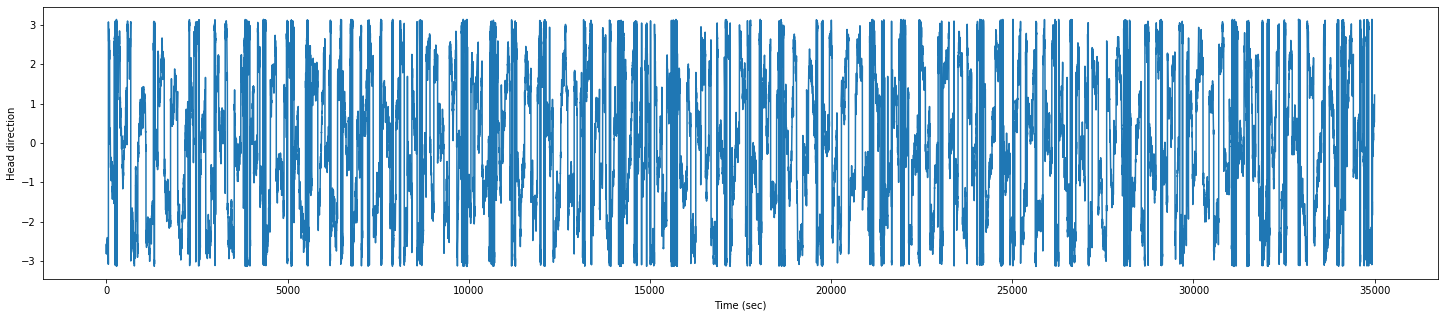

In [5]:
boxSize=80
samplingRate = 50
recordingTimeSec=700
samples=recordingTimeSec*samplingRate
dt = 1/samplingRate
stepSizeRatio = 25/samplingRate # to give it a speed of 25 cm per sec

print("Rec time:{} sec".format(recordingTimeSec))
print("dt:{} sec".format(dt))
print("samples:{}".format(samples))


position_x,position_y,head_direction = animal_trajectory.walk(samples,boxSize,stepSizeRatio)
animal_trajectory.plotPath(position_x,position_y,head_direction)
time = np.linspace(0,recordingTimeSec,samples)


plt.plot(time,position_x,label="x position")
plt.plot(time,position_y, label="y position")
plt.ylabel("Position")
plt.xlabel("Time (sec)")
plt.legend()
plt.show()


plt.plot(head_direction)
plt.ylabel("Head direction")
plt.xlabel("Time (sec)")

plt.show()

## Spatial selectivity 

We can model a firing field as a 2D gaussian distribution.

Peak rate: 4.00 Hz


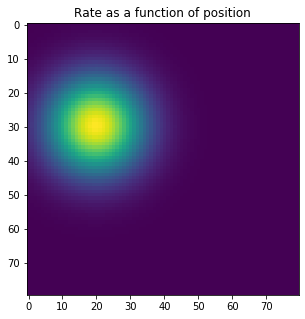

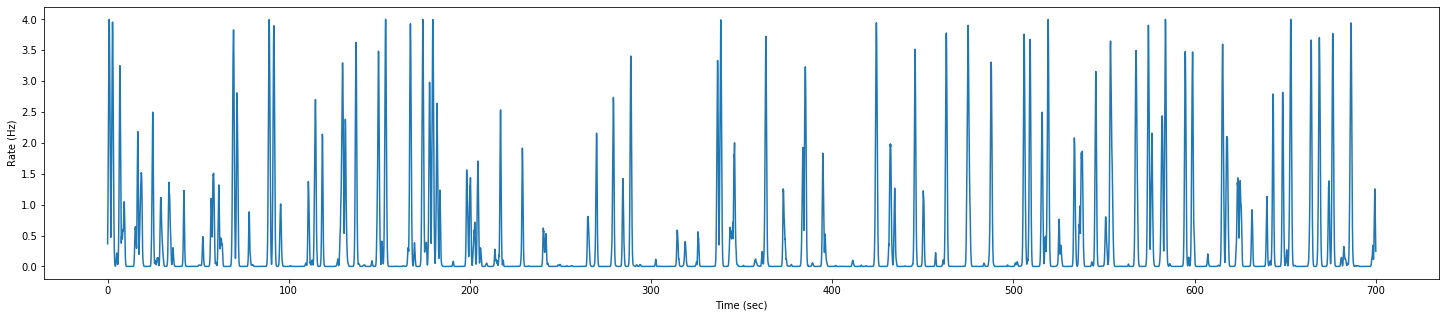

In [30]:
# mu and scale of the field
mx=20
my=30
sx=10
sy=10
PpeakRateHz=4

# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def gaus2d_rate(x=0, y=0, mx=0, my=0, sx=1, sy=1,peakRateHz=1):
    
    maxDist=gaus2d(x=mx, y=my, mx=mx, my=my, sx=sx, sy=sy)
    res = gaus2d(x=x, y=y, mx=mx, my=my, sx=sx, sy=sy)
    
    return res/maxDist*peakRateHz

x = np.linspace(0,boxSize,boxSize)
y = np.linspace(0,boxSize,boxSize)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
z = gaus2d_rate(x, y,mx,my,sx,sy,peakRateHz=PpeakRateHz)
print("Peak rate: {:.2f} Hz".format(z.max()))
plt.imshow(z)
plt.title("Rate as a function of position")
plt.show()


# get the position_rate from our path data
P_rate = gaus2d_rate(position_x, position_y,mx,my,sx,sy,peakRateHz=PpeakRateHz)
plt.plot(time,P_rate)
plt.ylabel("Rate (Hz)")
plt.xlabel("Time (sec)")
plt.show()

## Head-direction selectivity

The von Mises distribution is the equivalant of a Gaussian distribution for circular data.

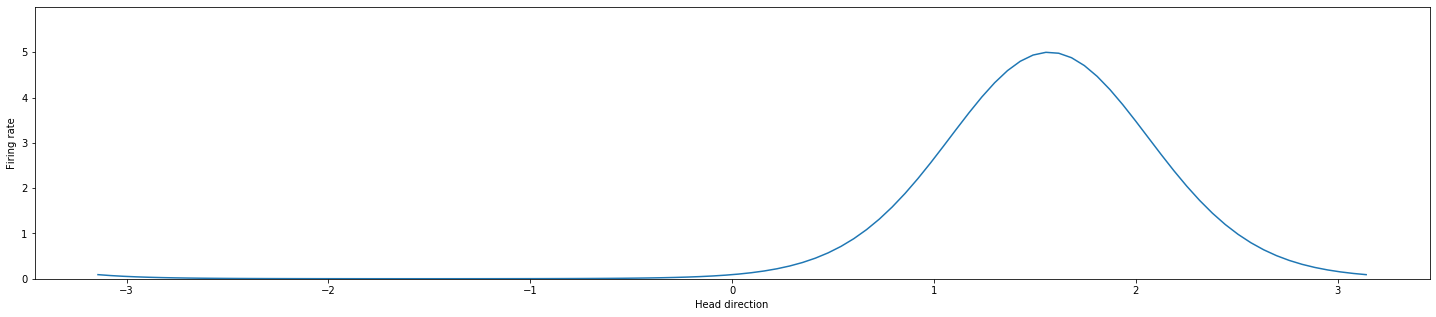

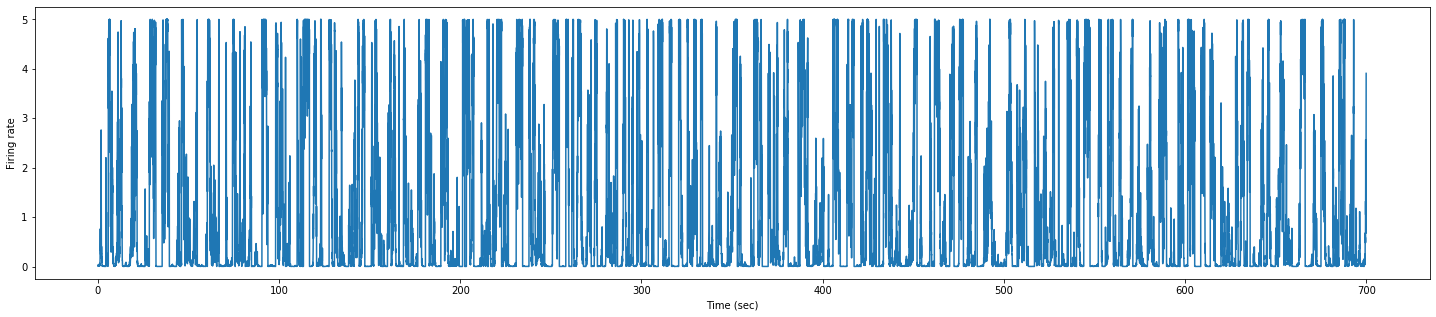

In [33]:
kappa=4
loc = np.pi/2
HpeakRateHz=5
x = np.linspace(-np.pi, np.pi, 100)

def vonmises_rate(x,loc,kappa,peakRateHz):
    maxDist=vonmises.pdf(loc,loc=loc,kappa=kappa)
    results = vonmises.pdf(x,kappa=kappa,loc=loc)
    return  results /maxDist*peakRateHz

y =vonmises_rate(x,loc,kappa,HpeakRateHz)
plt.plot(x, y)
plt.xlabel("Head direction")
plt.ylabel("Firing rate")
plt.ylim(0,y.max()+1)
plt.show()

H_rate = vonmises_rate(head_direction,loc,kappa,HpeakRateHz)
plt.plot(time, H_rate)
plt.xlabel("Time (sec)")
plt.ylabel("Firing rate")
plt.show()

## Combine spatial and directional selectivity

We can combine the 2 rate contribution using a multiplication term. This is how the model does it later. Is it how neurons are doing it? See Hardcastle et al. 2017.


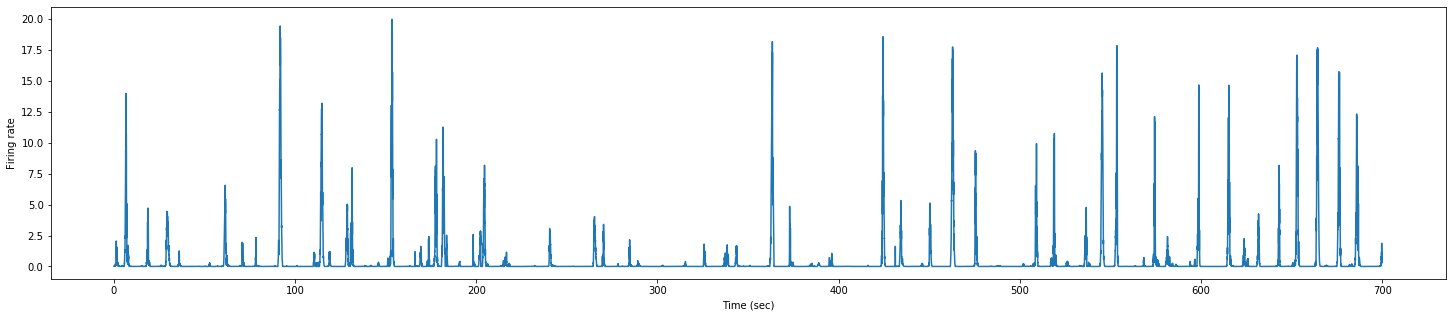

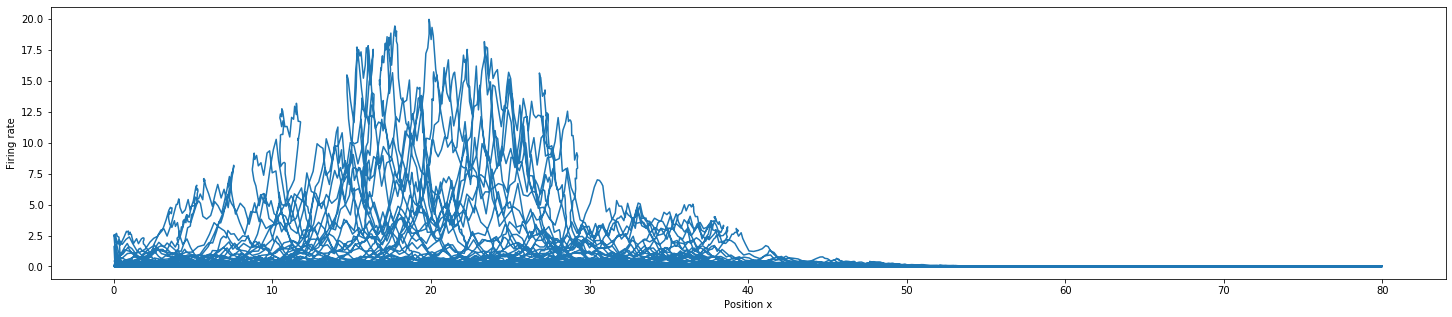

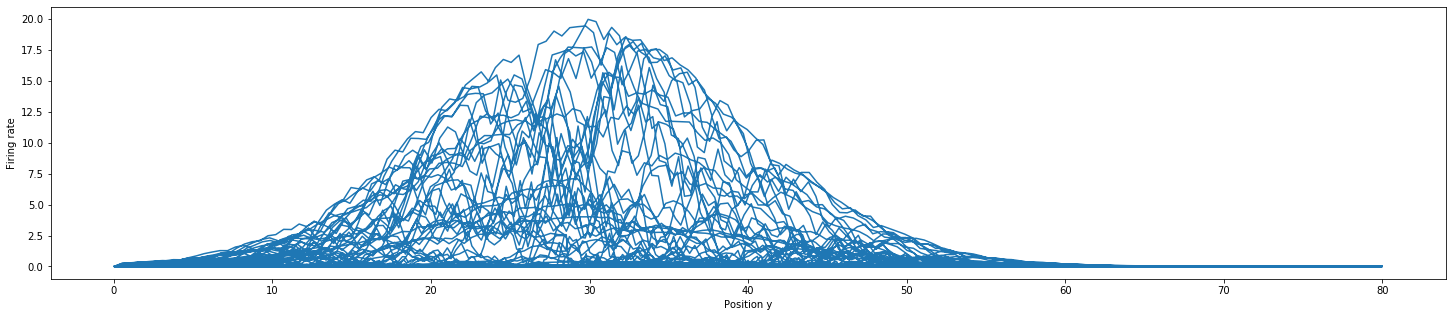

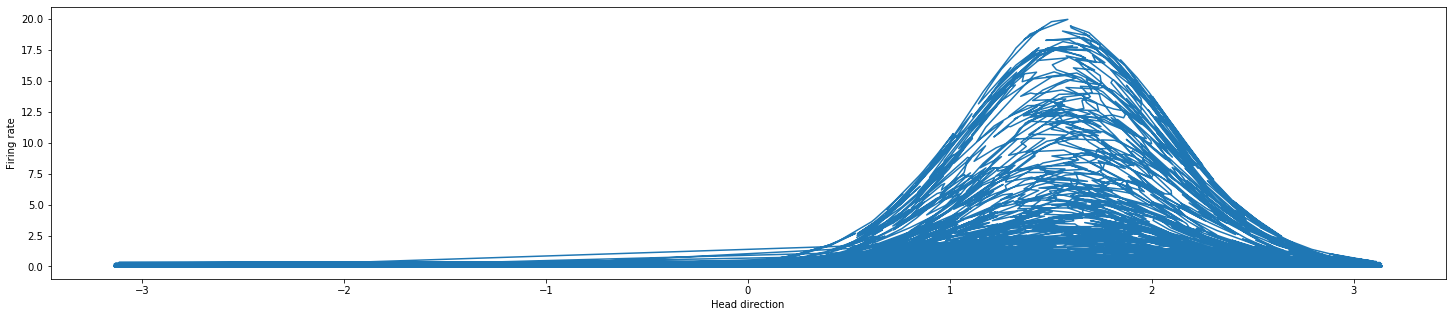

In [34]:
rate = P_rate * H_rate
plt.plot(time, rate)
plt.xlabel("Time (sec)")
plt.ylabel("Firing rate")
plt.show()

plt.plot(position_x, rate)
plt.xlabel("Position x")
plt.ylabel("Firing rate")
plt.show()

plt.plot(position_y, rate)
plt.xlabel("Position y")
plt.ylabel("Firing rate")
plt.show()

plt.plot(head_direction, rate)
plt.xlabel("Head direction")
plt.ylabel("Firing rate")
plt.show()

## Simulate a spike train

To model the neuron, we need a spike train with which we will adjust our model parameters. 

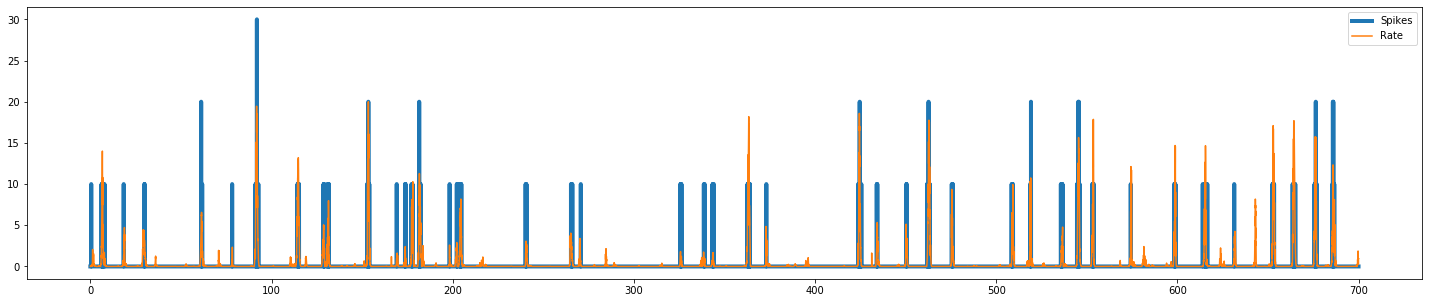

In [35]:
spikes = poisson.rvs(mu=rate*dt) # sample from a Poisson distribution. We pass the rate array to the function.
plt.plot(time,spikes*10,lw=4, label="Spikes")
plt.plot(time,rate, label="Rate")
plt.legend()
plt.show()

## Create a spatial firing rate map

We need to calculate an occupancy and a spike count histogram.

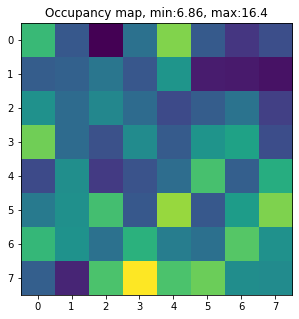

In [36]:
cmPerBin=10
nBins=boxSize/cmPerBin

occupancy_bins = [np.arange(0,nBins*cmPerBin+1,cmPerBin),
                  np.arange(0,nBins*cmPerBin+1,cmPerBin)]        
# calculate the occupancy map
occ,x_edges,y_edges = np.histogram2d(x = position_x, y= position_y, bins=occupancy_bins)
occ=occ*dt
plt.imshow(occ,interpolation="none")
plt.title("Occupancy map, min:{}, max:{}".format(occ.min(),occ.max()))
plt.show()

In [37]:
PspikeCounts=np.zeros_like(occ)
xBinIndices = (position_x/cmPerBin).astype(int)
yBinIndices = (position_y/cmPerBin).astype(int)
for i,count in enumerate(spikes): # ugly for loop
    PspikeCounts[yBinIndices[i],xBinIndices[i]]+= count   

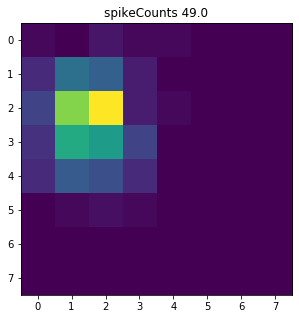

In [38]:
plt.imshow(PspikeCounts,interpolation="none")
plt.title("spikeCounts {}".format(PspikeCounts.max()))
plt.show()

Text(0.5, 1.0, 'P rate contribution, max:4.00 Hz')

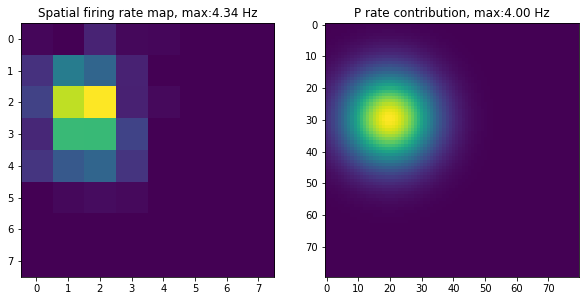

In [39]:
rate_map = PspikeCounts/occ
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rate_map,interpolation="none")
ax[0].set_title("Spatial firing rate map, max:{:.2f} Hz".format(rate_map.max()))

ax[1].imshow(z)
ax[1].set_title("P rate contribution, max:{:.2f} Hz".format(z.max()))

## Create a head-direction rate histrogram



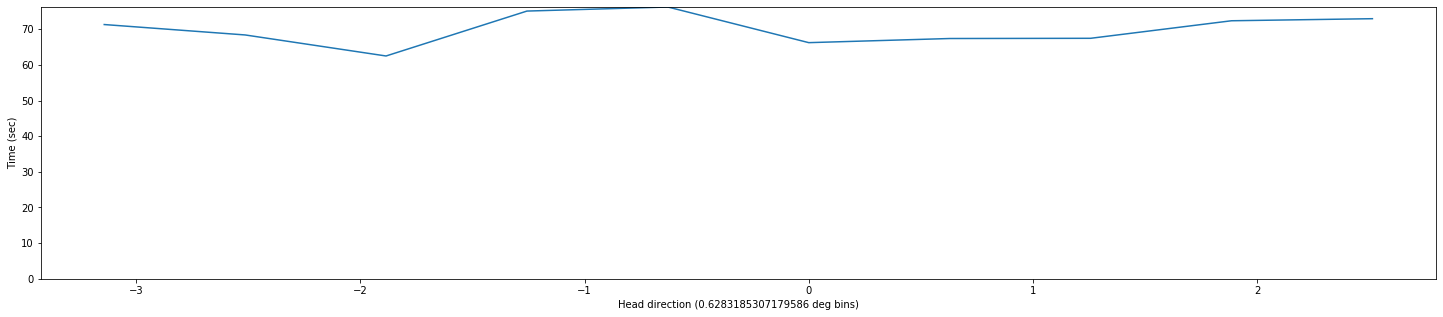

In [40]:
degPerBin=np.pi*2/10
nBins=2*np.pi/degPerBin
bins = np.arange(-np.pi,np.pi+degPerBin,degPerBin)
HOcc,edges = np.histogram(head_direction,bins= bins)
HOcc = HOcc*dt
plt.plot(edges[:-1],HOcc)
plt.xlabel("Head direction ({} deg bins)".format(degPerBin))
plt.ylabel("Time (sec)")
plt.ylim(0,HOcc.max())
plt.show()

In [41]:
HspikeCounts=np.zeros_like(HOcc)
binIndices = ((head_direction+np.pi)/degPerBin).astype(int)
binIndices=binIndices
print(binIndices.min(),binIndices.max())
for i,count in enumerate(spikes): # ugly for loop
    HspikeCounts[binIndices[i]]+= count

0 9


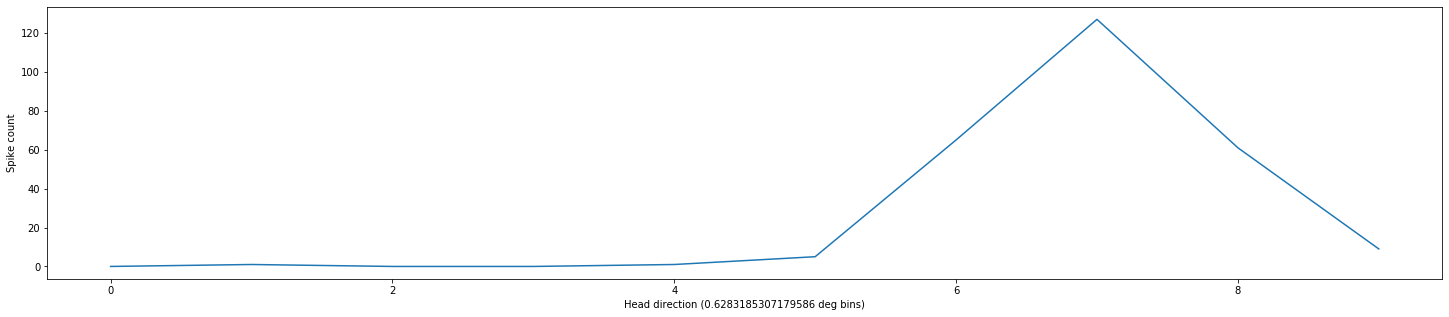

In [42]:
plt.plot(HspikeCounts)
plt.ylabel("Spike count")
plt.xlabel("Head direction ({} deg bins)".format(degPerBin))
plt.show()

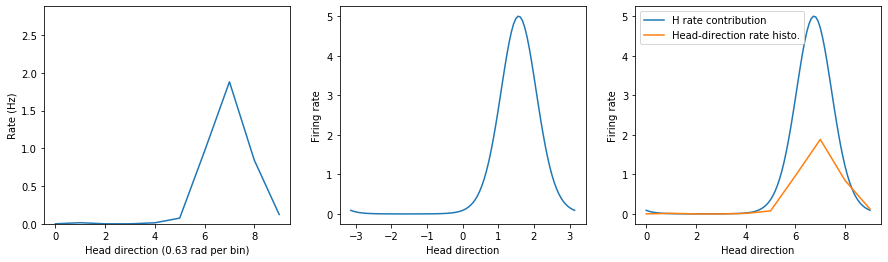

In [43]:
rate_hd_histo = HspikeCounts/HOcc
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(rate_hd_histo)
ax[0].set_ylim(0,rate_hd_histo.max()+1)
ax[0].set_ylabel("Rate (Hz)")
ax[0].set_xlabel("Head direction ({:.2f} rad per bin)".format(degPerBin))

ax[1].plot(x, y)
ax[1].set_xlabel("Head direction")
ax[1].set_ylabel("Firing rate")

ax[2].plot((x+np.pi)/(2*np.pi)*(nBins-1), y, label="H rate contribution")
ax[2].plot(rate_hd_histo,label="Head-direction rate histo.")
ax[2].set_xlabel("Head direction")
ax[2].set_ylabel("Firing rate")
ax[2].legend()
plt.show()



The multiplication of P and H rate contribution results in peak rates that are much higher than in the respective individual rate contribution.

## Model the neuron

We will model this neuron using the position data. 

$r = exp(\sum\limits_{i} X_{i}^T w_{i})*dt$


For the P and H components, we will need their behavioral state matrix $X_{i}^T$ and learned parameters $w_{i}$

### P behavioral state matrix and parameters

We can create a 3D (x,y,t) matrix and 2D (x,y) paramter matrix for now and linearize it when minimizing the log likelihood function.

(8, 8) (8, 8, 35000)


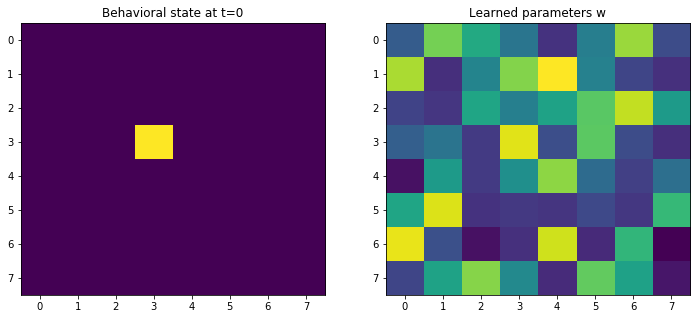

In [44]:
## Behavioral state 3d array
xBinIndices = (position_x/cmPerBin).astype(int)
yBinIndices = (position_y/cmPerBin).astype(int)
pXt = np.zeros((int(boxSize/cmPerBin), int(boxSize/cmPerBin) , position_x.shape[0]))
# pretty ugly and slow code I believe
for i in range(position_x.shape[0]):
    pXt[xBinIndices[i],yBinIndices[i],i] =+ 1

## Learned parameter 2d array
pw = np.random.uniform(-2,4,pXt.shape[0]*pXt.shape[1]).reshape(pXt.shape[0],pXt.shape[1])
print(pw.shape,pXt.shape)

fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(pXt[:,:,0],aspect="auto",interpolation="None")
ax[0].set_title("Behavioral state at t=0")
ax[1].imshow(pw,aspect="auto",interpolation="None")
ax[1].set_title("Learned parameters w")
plt.show()

### H behavioral state matrix and parameters

We get a 2D behavioral state matix and a 1D parameter vector.

(10, 35000) (10,)


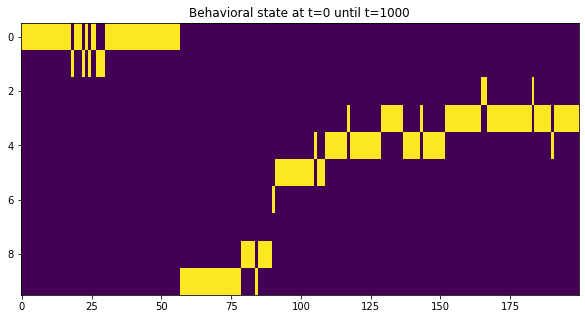

Text(0.5, 1.0, 'Learned parameters w')

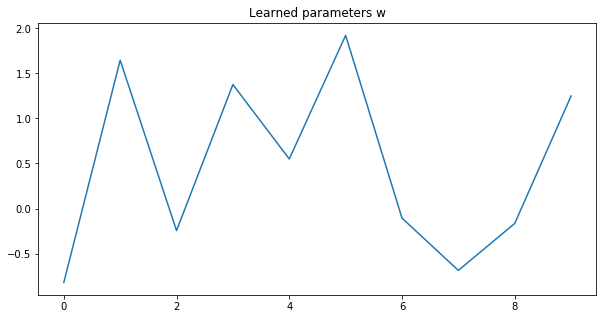

In [45]:
binIndices = ((head_direction+np.pi)/degPerBin).astype(int)
hXt = np.zeros((int(2*np.pi/degPerBin),head_direction.shape[0]))
for i in range(head_direction.shape[0]):
    hXt[binIndices[i],i]=+1

hw = np.random.uniform(-2,4,hXt.shape[0])

print(hXt.shape,hw.shape)
plt.figure(figsize=(10,5))
plt.imshow(hXt[:,0:200],aspect="auto",interpolation="None")
plt.title("Behavioral state at t=0 until t=1000")
plt.show()
plt.figure(figsize=(10,5))
plt.plot(hw)
plt.title("Learned parameters w")

## Calculate the firing rate predicted from the model

$r = exp(\sum\limits_{i} X_{i}^T w_{i})*dt$


In [46]:
pXtr = pXt.reshape(-1,pXt.shape[2])
pwr = pw.reshape(1,-1)

pComp = pwr@pXtr

In [47]:
hwr = np.expand_dims(hw,0)

hComp = hwr@hXt

In [48]:
s = pComp+hComp
print(s.shape)
r = np.exp(s)*dt

(1, 35000)


(35000,) (1, 35000)


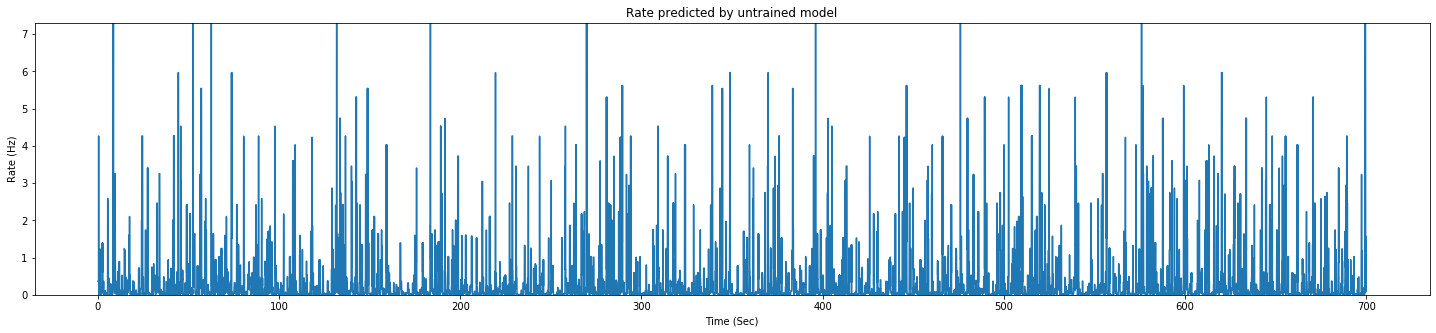

In [49]:
print(time.shape,r.shape)
plt.plot(time,r[0,:])
plt.ylim(0,r.max())
plt.ylabel("Rate (Hz)")
plt.xlabel("Time (Sec)")
plt.title("Rate predicted by untrained model")
plt.show()

## Minimine the objective function

We can now find the parameters $w$ that will maximize the log-likelihood function and smoothing penality

In [50]:
%%time

def objective_function(w,spikes,list_Xt):
    """
    Function for which we want to find the minimum
    
    We estimate the rate using our model.
    Than calculate the log likelihood of our spike train given our model.
    We calculate the smoothing penalty
    
    Returns 
    The negative log likelihood because our optimizer will look for the minimum
    """
    
    # set the parameters back to their array
    pw = w[0:pwr.shape[1]]
    hw = w[pwr.shape[1]:]
    pXtr = list_Xt[0]
    hXt = list_Xt[1]
    
    #print(pw.shape,hw.shape)
    
    pComp = np.expand_dims(pw,0)@pXtr
    hComp = np.expand_dims(hw,0)@hXt
    
    
    r = np.exp(pComp+hComp)   # *dt # do we need the *dt here?
    
    
    l = np.sum(spikes * np.log(r) - r - np.log(factorial(spikes))) # log likelihood, high is more likely
    #sm = beta * np.sum(0.5 * np.diff(w)**2) # smoothing penalty, 0 is very smooth,  large values are not smooth
    
    return -l #+sm


## set all parameters in a 1D array
w = np.hstack([pwr,hwr]).flatten()
list_Xt = [pXtr,hXt]


bnds = [(-15,10) for i in range(w.shape[0])]
x0=w
results = minimize(fun=objective_function,x0=x0,args=(spikes,list_Xt),bounds=bnds,options={"maxiter":20000,'disp':True})
print(results.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
CPU times: user 3min 38s, sys: 1min 36s, total: 5min 15s
Wall time: 39.9 s


In [51]:
print(results)

      fun: 912.0084213035368
 hess_inv: <74x74 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.29691831e-04, -3.41060515e-04, -2.61479725e-04, -1.02318155e-04,
       -1.81898941e-04,  1.13686828e-05,  1.13686828e-05,  1.13686828e-05,
        1.13686828e-05, -7.50333125e-04, -6.41193765e-03, -5.68434189e-04,
        7.95807860e-05, -9.66338127e-04,  1.13686828e-05,  1.13686828e-05,
       -3.16049411e-03, -3.86535246e-04, -6.02540240e-04, -9.89075489e-04,
       -1.17097442e-03,  4.09272618e-04,  1.13686828e-05,  0.00000000e+00,
       -3.18323148e-04,  4.77484721e-04,  1.69393389e-03, -6.59383663e-04,
       -4.09272618e-04, -2.72848412e-04,  1.13686828e-05,  1.13686828e-05,
        6.82121030e-04,  0.00000000e+00, -6.36646295e-04,  1.13686828e-05,
        1.13686828e-05,  1.13686828e-05,  1.13686828e-05,  1.13686828e-05,
        1.13686828e-05,  1.13686828e-05,  1.13686828e-05,  1.13686828e-05,
        1.13686828e-05,  1.13686828e-05,  2.27373657e-05,  2.27373657e-05,
  

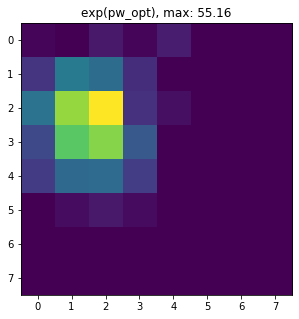

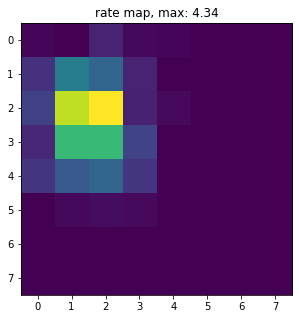

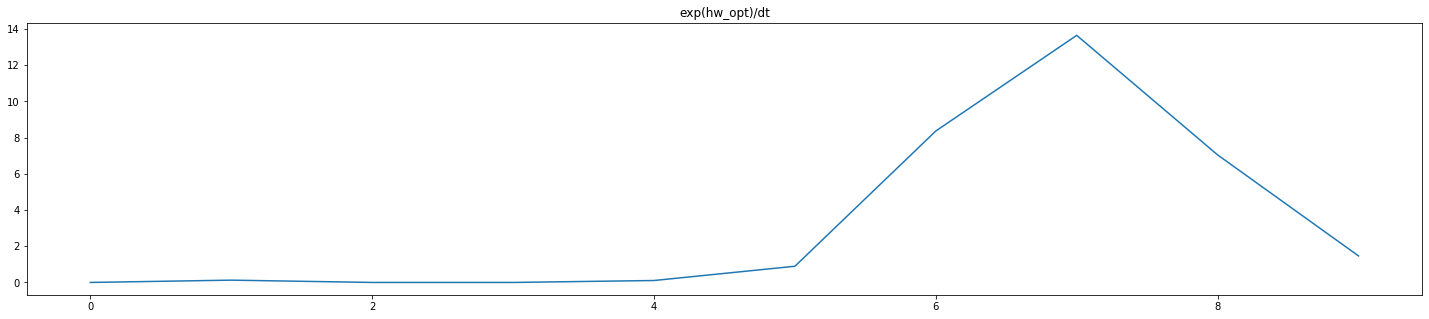

Text(0.5, 0, 'Head direction (0.63 rad per bin)')

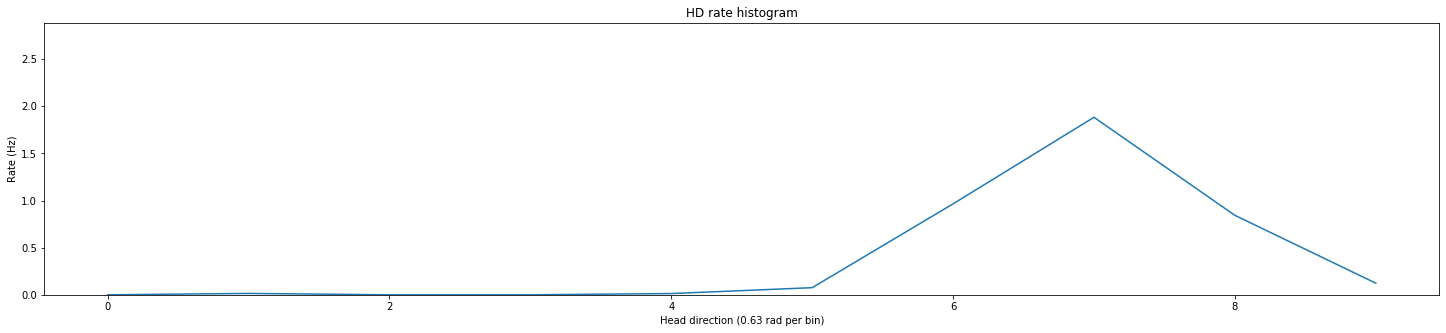

In [52]:
w_opt = results.x
pw_opt = w_opt[:pwr.shape[1]].reshape(pw.shape).T
hw_opt = w_opt[pwr.shape[1]:]

pw_opt_trans = np.exp(pw_opt)/dt
plt.imshow(pw_opt_trans)
plt.title("exp(pw_opt), max: {:.2f}".format(pw_opt_trans.max()))
plt.show()

plt.imshow(rate_map,interpolation="none")
plt.title("rate map, max: {:.2f}".format(rate_map.max()))
plt.show()

plt.title("exp(hw_opt)/dt")
plt.plot(np.exp(hw_opt)/dt)

plt.show()
plt.title("HD rate histogram")
plt.plot(rate_hd_histo)
plt.ylim(0,rate_hd_histo.max()+1)
plt.ylabel("Rate (Hz)")
plt.xlabel("Head direction ({:.2f} rad per bin)".format(degPerBin))

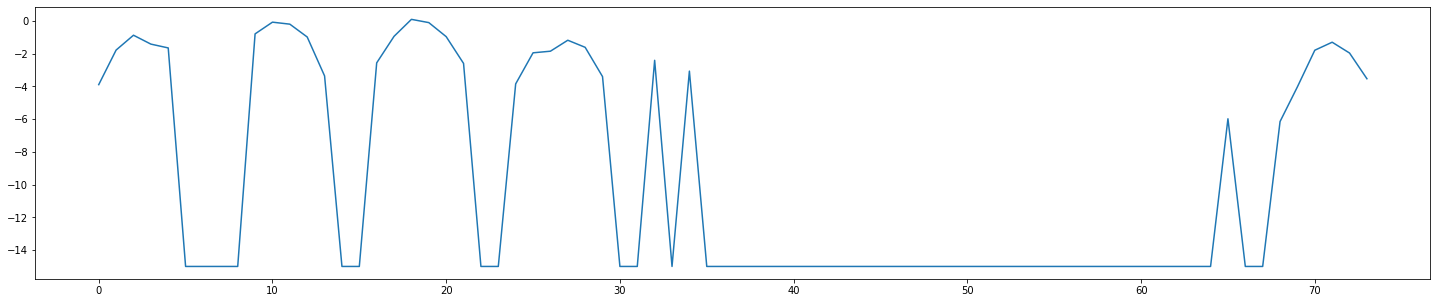

In [53]:
plt.plot(w_opt)

## For next time

* Why are the rate completely off?
* Implement the smoothing penalty for the diffent variables
* Why does the optimization sometimes fail?
